# LONG TERM NDVI CHART

Which dataset do you want to use? (Press 1 for Sentinel-2 / Press 2 for Landsat 8): 1
Enter the start date (YYYY-MM-DD): 2022-12-01
Enter the end date (YYYY-MM-DD): 2023-03-30
Enter the maximum cloud percentage (0-100): 10
Fetching Sentinel-2 images...
Enter the months you want to extract (comma-separated, e.g., 1,2,3 or a range e.g., 5-8): 12,01,02,03
Enter CSV file name (without .csv): raj1
Data saved to raj1.csv


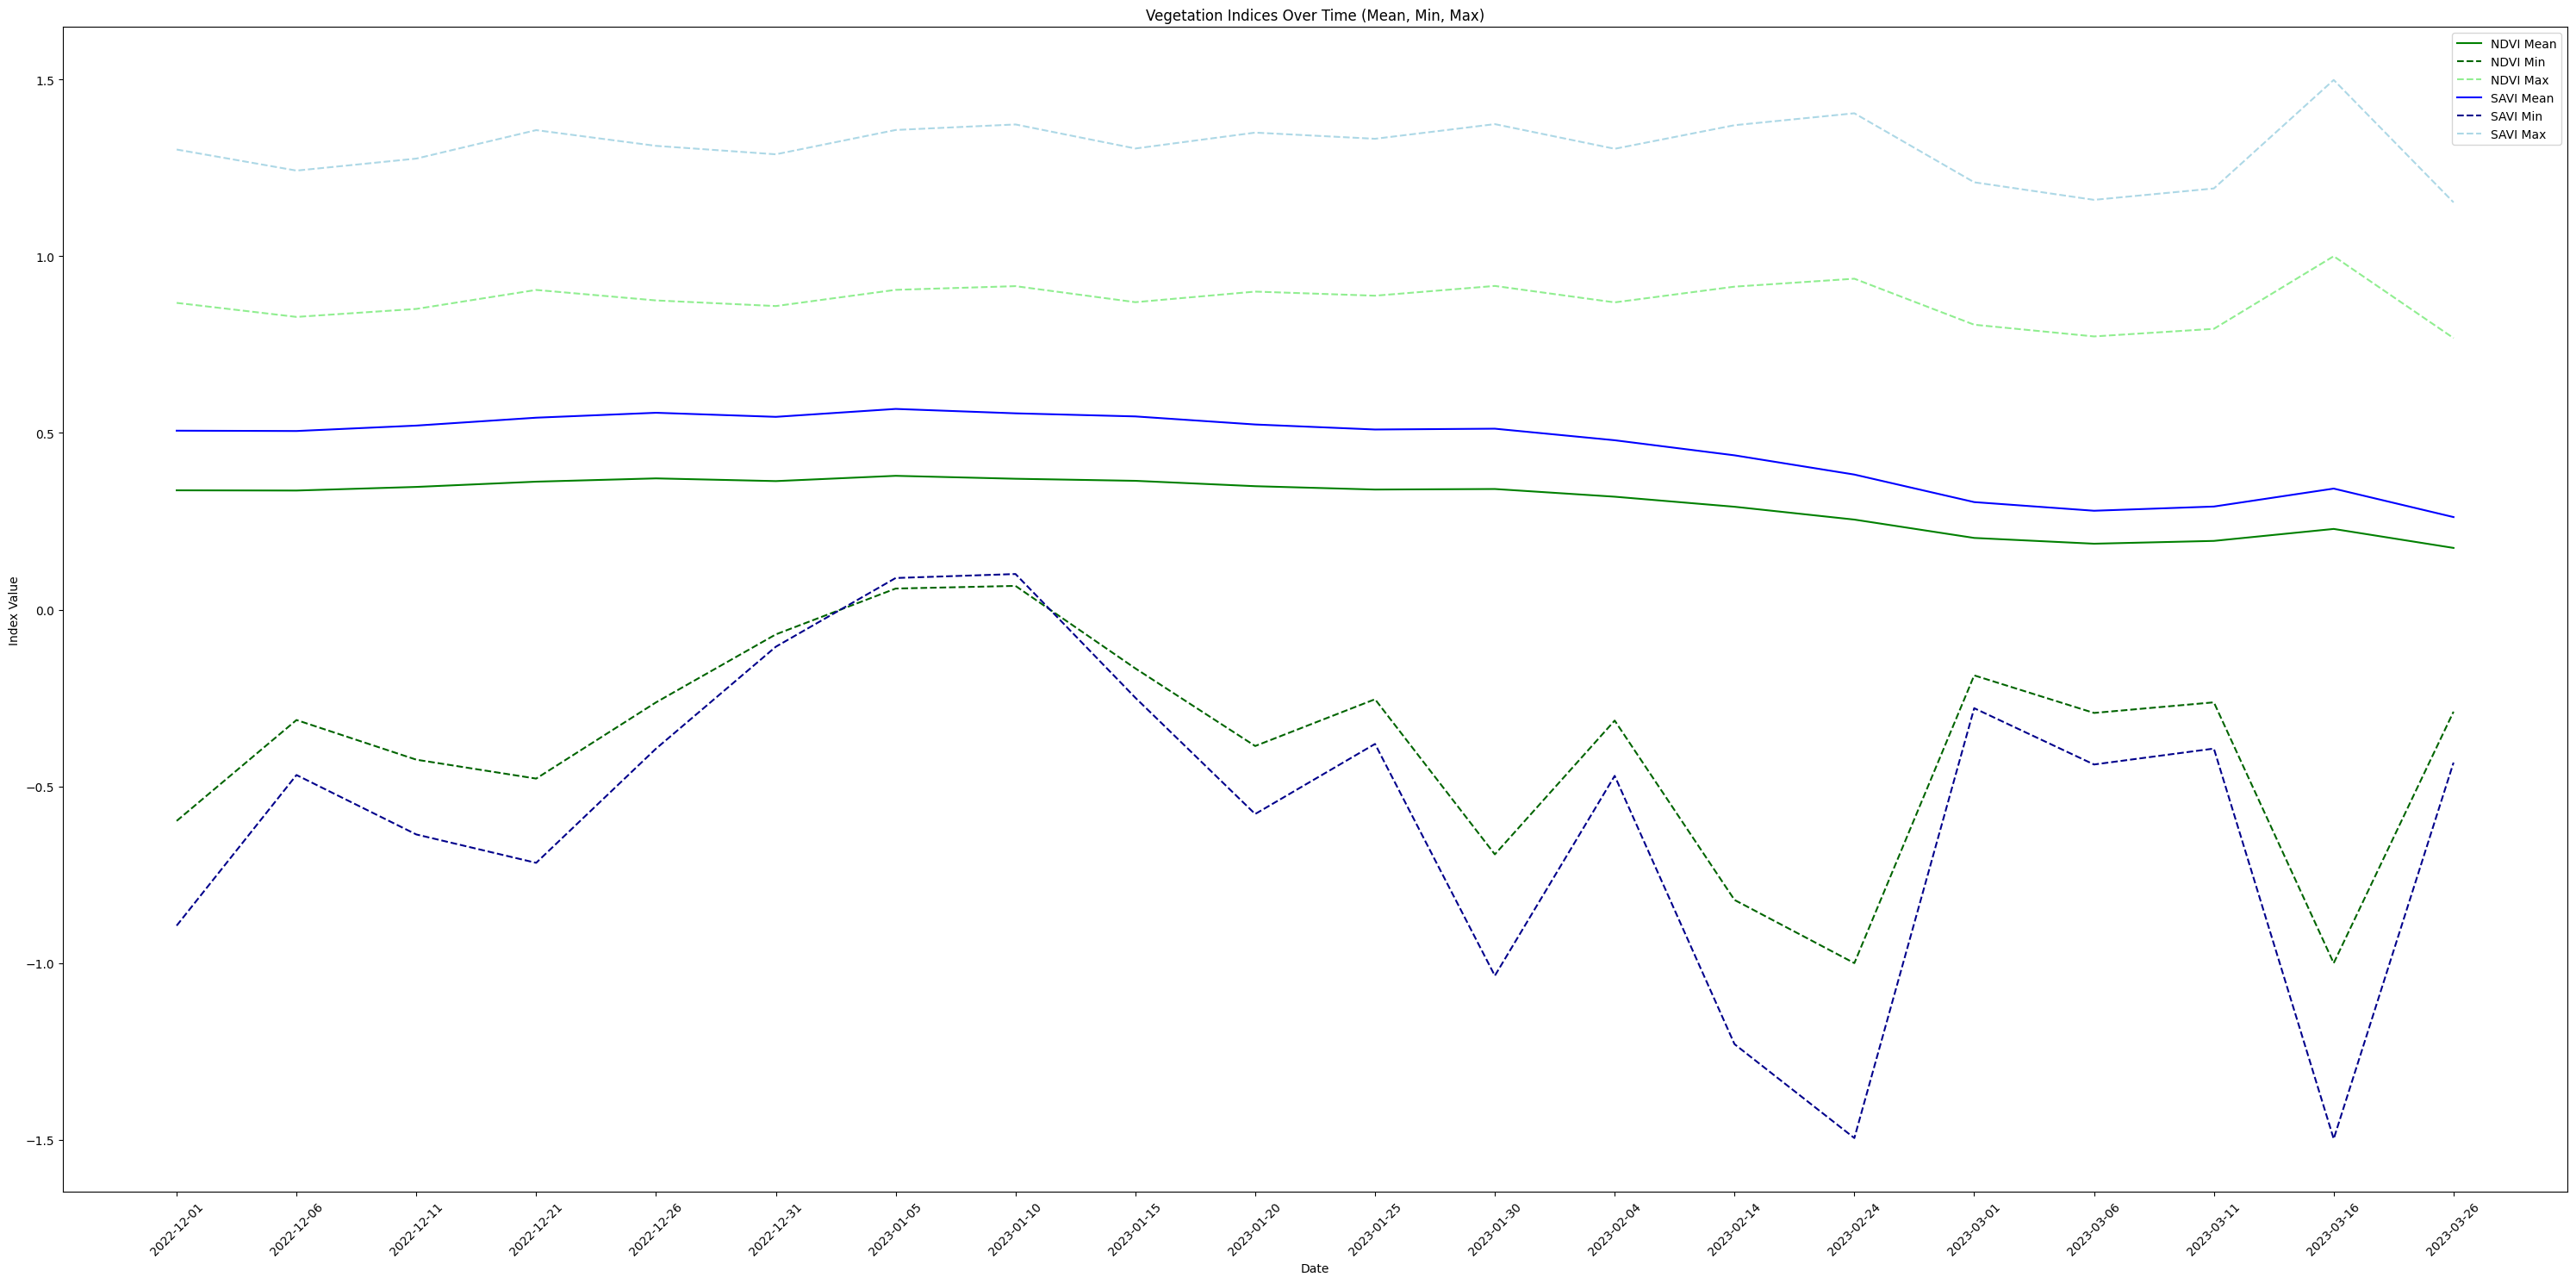

In [2]:
import ee
import folium
import json
import matplotlib.pyplot as plt
import csv

# Authenticate and initialize the Earth Engine API
ee.Authenticate()
ee.Initialize(project='ee-ishansethcareer1')

# Define the path to your GeoJSON file
geojson_file_path = 'Rajkot_village.geojson'  # Update this path

# Load your GeoJSON from the file
with open(geojson_file_path, 'r') as geojson_file:
    geojson = json.load(geojson_file)

# Extract the geometry and check if it is a Polygon or MultiPolygon
geometry_data = geojson['features'][0]['geometry']
geometry_type = geometry_data['type']
coordinates = geometry_data['coordinates']

if geometry_type == 'Polygon':
    polygon = ee.Geometry.Polygon(coordinates)
elif geometry_type == 'MultiPolygon':
    polygon = ee.Geometry.MultiPolygon(coordinates)
else:
    raise ValueError(f"Unsupported geometry type: {geometry_type}")

# Ask for the overlay GeoJSON file
overlay_geojson_file_path = 'Rajkot_village.geojson'

# Load the overlay GeoJSON
with open(overlay_geojson_file_path, 'r') as overlay_geojson_file:
    overlay_geojson = json.load(overlay_geojson_file)

# User input for dataset, date range, and cloud cover
data_source = int(input("Which dataset do you want to use? (Press 1 for Sentinel-2 / Press 2 for Landsat 8): "))
start_date = input("Enter the start date (YYYY-MM-DD): ")
end_date = input("Enter the end date (YYYY-MM-DD): ")
max_cloud_percentage = float(input("Enter the maximum cloud percentage (0-100): "))

# Load data based on user choice
if data_source == 1:
    image_collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
        .filterBounds(polygon) \
        .filterDate(start_date, end_date) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', max_cloud_percentage)) \
        .select(['B2', 'B3', 'B4', 'B8'])
    print("Fetching Sentinel-2 images...")
elif data_source == 2:
    image_collection = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
        .filterBounds(polygon) \
        .filterDate(start_date, end_date) \
        .select(['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5'])
    print("Fetching Landsat 8 images...")
else:
    raise ValueError("Invalid choice! Please choose 1 for Sentinel-2 or 2 for Landsat 8.")

# Ask user for multiple months (comma-separated or range of months)
months_input = input("Enter the months you want to extract (comma-separated, e.g., 1,2,3 or a range e.g., 5-8): ")

# Parse the user input
months = []
if '-' in months_input:  # Handle the range case
    start_month, end_month = map(int, months_input.split('-'))
    months = list(range(start_month, end_month + 1))
else:  # Handle individual months
    months = list(map(int, months_input.split(',')))

# Ensure the months are within valid range (1-12)
months = [month for month in months if 1 <= month <= 12]

# Parse start and end date to extract years
start_year = int(start_date.split('-')[0])
end_year = int(end_date.split('-')[0])

# Filter the image collection by specific months within the date range
image_collection = image_collection.filter(ee.Filter.calendarRange(min(months), max(months), 'month'))
image_collection = image_collection.filterDate(f'{start_year}-01-01', f'{end_year}-12-31')

# Function to calculate NDVI and SAVI (EVI removed)
def calculate_indices(image):
    if data_source == 1:  # Sentinel-2
        ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
        savi = image.expression(
            '((NIR - Red) / (NIR + Red + L)) * (1 + L)', {
                'NIR': image.select('B8'),
                'Red': image.select('B4'),
                'L': 0.5
            }).rename('SAVI')
    elif data_source == 2:  # Landsat 8
        ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
        savi = image.expression(
            '((NIR - Red) / (NIR + Red + L)) * (1 + L)', {
                'NIR': image.select('SR_B5'),
                'Red': image.select('SR_B4'),
                'L': 0.5
            }).rename('SAVI')
    return image.addBands(ndvi).addBands(savi)

# Map the function over the image collection
image_collection = image_collection.map(calculate_indices)

# Function to calculate statistics (excluding EVI)
def get_statistics(image):
    date = image.date().format('YYYY-MM-dd')
    stats = {
        'date': date,
        'NDVI_mean': image.select('NDVI').reduceRegion(ee.Reducer.mean(), polygon, 30).get('NDVI'),
        'NDVI_min': image.select('NDVI').reduceRegion(ee.Reducer.min(), polygon, 30).get('NDVI'),
        'NDVI_max': image.select('NDVI').reduceRegion(ee.Reducer.max(), polygon, 30).get('NDVI'),
        'SAVI_mean': image.select('SAVI').reduceRegion(ee.Reducer.mean(), polygon, 30).get('SAVI'),
        'SAVI_min': image.select('SAVI').reduceRegion(ee.Reducer.min(), polygon, 30).get('SAVI'),
        'SAVI_max': image.select('SAVI').reduceRegion(ee.Reducer.max(), polygon, 30).get('SAVI'),
    }
    return ee.Feature(None, stats)

# Retrieve statistics
statistics = image_collection.map(get_statistics).getInfo()

# Check if statistics are empty
if not statistics['features']:
    raise ValueError("No data available for the specified date range and cloud cover criteria.")

# Generate CSV and plot data
dates, ndvi_mean, ndvi_min, ndvi_max, savi_mean, savi_min, savi_max = [], [], [], [], [], [], []
for feature in statistics['features']:
    props = feature['properties']
    dates.append(props['date'])
    ndvi_mean.append(props['NDVI_mean'])
    ndvi_min.append(props['NDVI_min'])
    ndvi_max.append(props['NDVI_max'])
    savi_mean.append(props['SAVI_mean'])
    savi_min.append(props['SAVI_min'])
    savi_max.append(props['SAVI_max'])

# Saving data to CSV
csv_file_name = input("Enter CSV file name (without .csv): ") + ".csv"
with open(csv_file_name, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Date', 'NDVI Mean', 'NDVI Min', 'NDVI Max', 'SAVI Mean', 'SAVI Min', 'SAVI Max'])
    for i in range(len(dates)):
        writer.writerow([dates[i], ndvi_mean[i], ndvi_min[i], ndvi_max[i], savi_mean[i], savi_min[i], savi_max[i]])

print(f"Data saved to {csv_file_name}")

# Plotting the data with min and max values (without EVI)
plt.figure(figsize=(30, 15))
plt.plot(dates, ndvi_mean, label='NDVI Mean', color='green')
plt.plot(dates, ndvi_min, label='NDVI Min', linestyle='--', color='darkgreen')
plt.plot(dates, ndvi_max, label='NDVI Max', linestyle='--', color='lightgreen')

plt.plot(dates, savi_mean, label='SAVI Mean', color='blue')
plt.plot(dates, savi_min, label='SAVI Min', linestyle='--', color='darkblue')
plt.plot(dates, savi_max, label='SAVI Max', linestyle='--', color='lightblue')

plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.title('Vegetation Indices Over Time (Mean, Min, Max)')
plt.legend()
plt.tight_layout()
plt.show()

# Create a Folium map centered on the region of interest
roi_center = polygon.centroid().coordinates().getInfo()[::-1]
m = folium.Map(location=roi_center, zoom_start=8)

# Mean indices for map visualization
mean_ndvi = image_collection.select('NDVI').mean().clip(polygon)
mean_savi = image_collection.select('SAVI').mean().clip(polygon)

# Min and Max indices for map visualization
min_ndvi = image_collection.select('NDVI').min().clip(polygon)
max_ndvi = image_collection.select('NDVI').max().clip(polygon)
min_savi = image_collection.select('SAVI').min().clip(polygon)
max_savi = image_collection.select('SAVI').max().clip(polygon)

# Visualization parameters
vis_params = {
    'NDVI': {'min': -1, 'max': 1, 'palette': ['red', 'yellow', 'green']},
    'SAVI': {'min': -1, 'max': 1, 'palette': ['red', 'yellow', 'green']}
}

# Add layers for mean NDVI and SAVI
for index, mean_image in zip(['NDVI', 'SAVI'], [mean_ndvi, mean_savi]):
    map_id = mean_image.getMapId(vis_params[index])
    folium.raster_layers.TileLayer(
        tiles=map_id['tile_fetcher'].url_format,
        attr='Google Earth Engine',
        name=f'Mean {index}',
        overlay=True,
        control=True
    ).add_to(m)

# Add layers for min and max NDVI and SAVI
for index, (min_image, max_image) in zip(['NDVI', 'SAVI'], [(min_ndvi, max_ndvi), (min_savi, max_savi)]):
    for layer_type, image in zip(['Min', 'Max'], [min_image, max_image]):
        map_id = image.getMapId(vis_params[index])
        folium.raster_layers.TileLayer(
            tiles=map_id['tile_fetcher'].url_format,
            attr='Google Earth Engine',
            name=f'{layer_type} {index}',
            overlay=True,
            control=True
        ).add_to(m)

# Overlay the user-provided GeoJSON with transparent fill, black boundary, and weight of 2
folium.GeoJson(
    overlay_geojson,
    name="Overlay GeoJSON",
    style_function=lambda feature: {
        "fillColor": "transparent",
        "color": "black",
        "weight": 2,
        "fillOpacity": 0
    },
    tooltip=folium.GeoJsonTooltip(fields=["VILLAGENAM"], aliases=["Name: "])
).add_to(m)

# Add a layer control panel
folium.LayerControl().add_to(m)

# Display the map
m


In [ ]:
import ee

In [ ]:
ee.Authenticate()

True

In [ ]:
ee.Initialize(project='ee-ishansethcareer1')

EEException: Caller does not have required permission to use project ee-ishansethcareer1. Grant the caller the roles/serviceusage.serviceUsageConsumer role, or a custom role with the serviceusage.services.use permission, by visiting https://console.developers.google.com/iam-admin/iam/project?project=ee-ishansethcareer1 and then retry. Propagation of the new permission may take a few minutes.